# Quantum energy teleportation protocol with minimal model
https://doi.org/10.1103/PhysRevApplied.20.024051

### Import packages

Import necessary packages to create and simulate the protocol.

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator

## Model

### Theory

In [ ]:
# Parameters
h = 1; k = 1; 

# Define basis
ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)

# Define base operators
I = Operator.from_label('II').to_matrix();
Z_A = Operator.from_label('IZ').to_matrix(); Z_B = Operator.from_label('ZI').to_matrix();
X_AB = Operator.from_label('XX').to_matrix(); X_A = Operator.from_label('IX').to_matrix();
Y_B = Operator.from_label('YI').to_matrix()

# Ground state
ket_g = np.sqrt(1/2)*np.sqrt(1-h/np.sqrt(h**2+k**2))*ket_00 - np.sqrt(1/2)*np.sqrt(1+h/np.sqrt(h**2+k**2))*ket_11
state_g = Statevector(ket_g)

# Hamiltonians
H_A = h*Z_A + h**2/np.sqrt(h**2+k**2) * I
H_B = h*Z_B + h**2/np.sqrt(h**2+k**2) * I
V = 2*k*X_AB + 2*k**2/np.sqrt(h**2+k**2) * I

# Define the angle of rotation theta
theta = np.arctan2(h*k, h**2 + 2*k**2)/2

# Define operations
def P_0(mi):
    """Projective measurement on qubit 0 or A"""
    return 1/2 * (I + mi*X_A)

def U_1(mi):
    """Conditional unitary operation"""
    return np.cos(theta) * I - 1j*mi*np.sin(theta) * Y_B

# Final State Density Matrix
P_QET = np.zeros((4, 4), dtype=complex)
for mi in [-1, 1]:
    P_QET = U_1(mi)@P_0(mi)@(ket_g@ket_g.conj().T)@P_0(mi)@U_1(mi).conj().T + P_QET

# Final state energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real # or -(h*k* np.sin(2*phi) - (h**2+2*k**2) * (1-np.cos(2*phi))) / np.sqrt(h**2 + k**2)

# Show results
display('Ground State:', Operator(state_g).draw('latex'))
display('Final State:', Operator(P_QET).draw('latex'))

print(f"""
Ground State Energies:
<H_A> = {(ket_g.T@H_A@ket_g)[0][0].real},
<H_B> = {(ket_g.T@H_B@ket_g)[0][0].real},
<V>   = {(ket_g.T@V@ket_g)[0][0].real}.
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
V   = {E_V},
E_A = {E_A},
E_B = {E_B}.
""")


'Ground State:'

<IPython.core.display.Latex object>

'Final State:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = 0.0
<H_B> = 0.0
<V> = -1.1102230246251565e-16
            
Final Energies:
H_A = 0.7071067811865476,
H_B = 0.2598931856865896,
V = -0.37464081962673673,
E_A = 0.3324659615598109,
E_B = -0.11474763394014716.



### Create circuit

In [ ]:
def qet(h,k):

    # Generate circuit
    qc = QuantumCircuit(2,2, metadata={'h':h, 'k':k})

    #Prepare the ground state
    alpha= -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*alpha,0)
    qc.cx(0,1)

    qc.barrier()
    # Projective measurement on A*
    qc.h(0)
    qc.barrier()

    # Condicional operation on B
    theta = np.arctan2(h*k,h**2+2*k**2)
    
    qc.cry(-theta,0,1)
    
    qc.x(0)
    qc.cry(theta,0,1)
    qc.x(0)

    qc.barrier()
    return qc

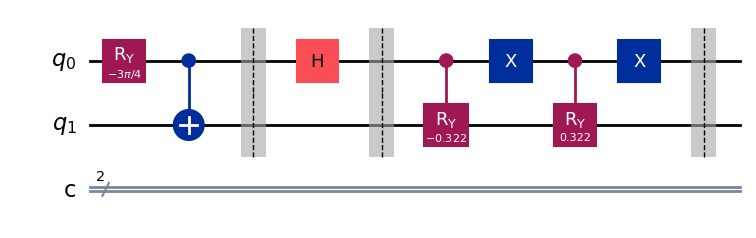

In [13]:
# Show circuit
qet(1,1).draw('mpl')

## Simulate circuit

### Simulate circuits with aer simulator

In [ ]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1; k = 1
n_shots = 100000

# Generate circuits
qc = qet(h, k)
qc_H.measure(0,1)
qc_H.h(0)
qc_H.measure_all(add_bits=False)

qc = qet(h, k)
qc_V.h(1)
qc_V.measure_all(add_bits=False)

# Run job with Sampler
sim_H = simulator.run(qc_H, shots=n_shots)
sim_V = simulator.run(qc_V, shots=n_shots)

### Show results for simulated circuit $H$

H_A = 0.7096867811865475 ± 0.003162267135458356
H_B = 0.25952678118654743 ± 0.0028278474916444835


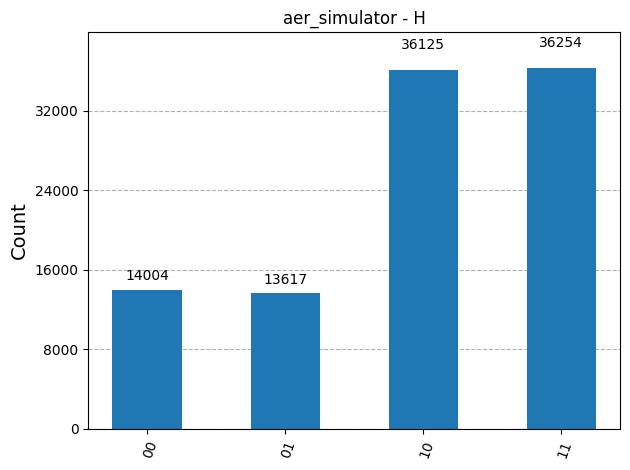

In [ ]:
# Extract results
result = sim_H.result()
counts = result.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1] 
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Show results
print(f"H_A = {ene_A} ± {np.std(error_A)/np.sqrt(n_shots)}")
print(f"H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
plot_histogram(counts, title="aer_simulator - H")

### Show results for simulated circuit V

V = 1.4136935623730948 ± 0.006324474354126198


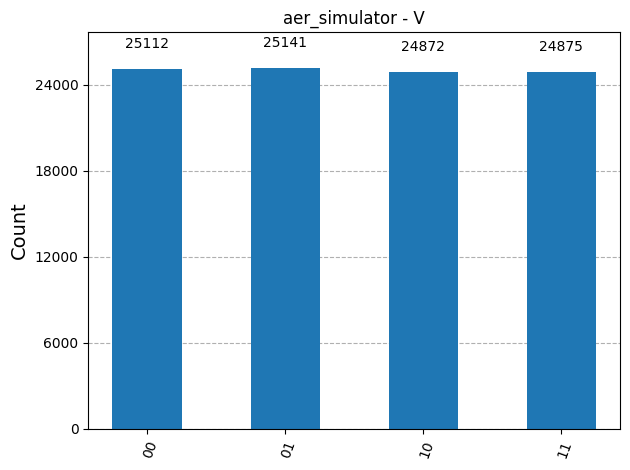

In [ ]:
# Extract results
result = sim_V.result()
counts = result.get_counts()

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Show results
print(f"V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
plot_histogram(counts, title="Simulated V")

## Run circuit on hardware

### Import IBM packages

In [1]:
from qiskit_ibm_runtime import (QiskitRuntimeService, 
                                Batch, 
                                SamplerV2 as sampler, 
                                EstimatorV2 as estimator)
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

### Get backend

In [ ]:
# Log in IBM platform
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy()
print(backend.name)

ibm_fez


### Run job with Sampler

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]
n_shots = 3000

# Run job in Batch mode
with Batch(backend=backend)
    

    # initiate sampler and configure error mitigation
    sampler = sampler()
    options = sampler.options
    options.dynamical_decoupling.enable = True
    options.twirling.enable_gates = True
    options.twirling.enable_measure= True

    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits
        circuit_H = qet(h,k)
        circuit_H.measure_all(add_bits=False)
        transpiled_H = transpile(circuit_H, backend=backend, optimization_level=3)

        circuit_V = qet(h,k)
        circuit_V.barrier()
        circuit_V.h(1)
        circuit_V.measure_all(add_bits=False)
        transpiled_V = transpile(circuit_V, backend=backend, optimization_level=3)
        
        # Run job
        job_A = sampler.run([(transpiled_H), (transpiled_V)], shots=n_shots)
        job_A.update_tags([f'k={k},h={h}','error mitigated','sampler','MM',f'{n_shots}'])  # Add tags to job
        print(f"Sampler, ID = {job_A.job_id()}, h = {h} k = {k}")

### Run job with Estimator

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]

# Configure the transpiler
transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

#  Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h = variable[0]
        k = variable[1]
        observables = [SparsePauliOp('ZI', h), SparsePauliOp('XX', 2*k)]

        # Generate circuit
        circuit_T = qet(h,k)
        circuit_T.h(0)
        transpiled_T = transpiler.run(circuit_T)
        
        # Run jobs
        transpiled_observables = [observable.apply_layout(transpiled_T.layout) for observable in observables] 
        job_B = estimator(options={'resilience_level':2}).run([(transpiled_T, transpiled_observables)]) # transpiled_observables[0] or [1] to run separately
        job_B.update_tags([f'k={k},h={h}','error mitigated','estimator','MM']) # Add tags
        print(f"Estimator, ID = {job_B.job_id()}, h = {h} k = {k}")         

### Show results for circuit H

In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[0]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[0]
value_error = result.data.stds[0]

# Parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energies
ene_B = (h**2)/(np.sqrt(h**2+k**2))
est_B = exp_value + ene_B

# Error array
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots       
        for i in range(count):
            error_B.append(h*(-1)**int(bit_string[1]))          

# Show results
print(f"  Sampler H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"Estimator H_B = {est_B} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - H")

NameError: name 'service' is not defined

### Show results for circuit V

In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[1]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[1]
value_error = result.data.stds[1]

# Parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))
est_V = exp_value + ene_V

# Error array
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots    
        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))                              

# Show results
print(f"  Sampler V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
print(f"Estimator V = {est_V} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - V")

Sampler V = -0.3913496825570424 ± 0.03464270935119016
Estimated V = -0.49204472171818847 ± 0.058250861113651346
